Tips from http://blog.qure.ai/notes/semantic-segmentation-deep-learning-review
- Use encoder-decoder, upsampling by doing a reverse convolution and concatenating with the feature maps that were before the downsampling or by copying the index of the max-pooling
- Use VGG convolution layers trained on imagenet and remove the final FC layers or use ResNet for the encoder.
- Use dillated convolution rather than downsampling (they still do some pooling for downsampling, but most of the increase in field of view is from the dillatation)
- It is common to have a predicted segmentation map that is 1/8th of the input image size. One uses interpolation to get the final segmentation map.
- Use a fully connected CRF after interpolation (trained separately)
- Use residual conv unit, multi-resolution fusion and chained residual pooling to combine multi-resolution input
- Very large kernel are useful for the classification part of the network. They play a role similar as the FC layer at the end of a classifier. They are better to use a large receptive field that deep network like ResNet even though ResNet has theoretically a very large receptive field. kxk convolution are approximated by 1xk+kx1 convolutions to reduce the number of parameter and the computational expense.

What I think about this particular case (road detection):
- It is not needed to have large field of view, but it is important to have a good resolution.

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from keras import layers, regularizers
#from keras import models
from keras.models import Model, Sequential
from keras import callbacks
from time import time
from keras import backend as K
#import tensorflow as tf
K.set_image_data_format("channels_first")

Using TensorFlow backend.


In [2]:
modelList = []
history = []
xaxis = []
class TimeHistory(callbacks.Callback):
    def __init__(self, seconds=np.inf):
        super(callbacks.Callback, self).__init__()
        self.seconds = seconds
    def on_train_begin(self, logs={}):
        self.times = []
        self.start = time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.start)
        if time() - self.start > self.seconds: # if not defined, there is no limit since it is np.inf
            self.model.stop_training = True
            print('Stopping after %s seconds.' % self.seconds)
                
def Plot(i, text = 'val_acc', label = ''):
    plt.plot(xaxis[i], history[i].history[text], label = label)
    
def retrain(i_model, batchsize=99, nepochs=10, timelimit=np.inf):
    time_callback = TimeHistory(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    history[i_model].history = list(history[i_model].history)
    history[i_model].history.append(modelList[i_model].fit_generator(generator(batchsize), 
                    steps_per_epoch(989-yVal.shape[0])//batchsize,
                   epochs=nepochs, verbose=2, validation_data=([xMulVal,xPanVal],yVal),callbacks=[time_callback, es]))
    xaxis[i_model].append(time_callback.times)
    
def generator(batchsize):
    while True:
        for i in range(10):
            #print('  file', i)
            xMul = np.load(r'..\data\xMul'+str(i)+'.npy')
            xPan = np.load(r'..\data\xPan'+str(i)+'.npy')
            y = np.load(r'..\data\y325_'+str(i)+'.npy') # I will use the 325x325 resolution for the target
            xMul = (xMul - 414.1505843473475)/271.51272549425477
            xPan = (xPan - 532.8910415421709)/318.8023222567299
            j=0
            while j<xMul.shape[0]:
                #print('    ',j, '/', xMul.shape[0])
                yield ([xMul[j:j+batchsize], xPan[j:j+batchsize]], y[j:j+batchsize])
                j+= batchsize
                
# load Validation data
xMulVal = np.load(r'..\data\xMulVal.npy')
xPanVal = np.load(r'..\data\xPanVal.npy')
yVal = np.load(r'..\data\yVal325.npy')
xMulVal = (xMulVal - 414.1505843473475)/271.51272549425477
xPanVal = (xPanVal - 532.8910415421709)/318.8023222567299

print(xMulVal.shape,xPanVal.shape, yVal.shape)

def train(batchsize=99, nepochs=10, timelimit=np.inf):
    XMul = layers.Input(shape=xMulVal.shape[1:])
    XPan = layers.Input(shape=xPanVal.shape[1:])
    
    # Actual neural netowrk given by function NN
    Y = NN(XMul,XPan)
    
    model = Model(inputs=[XMul,XPan], outputs=Y)

    time_callback = TimeHistory(timelimit)
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchsize), steps_per_epoch=882//batchsize,
                   epochs=nepochs, verbose=2, validation_data=([xMulVal,xPanVal],yVal),callbacks=[time_callback, es]))
    xaxis.append(time_callback.times)
    modelList.append(model) 

(99, 8, 325, 325) (99, 1, 1300, 1300) (99, 325, 325)


I need to downsample 1300 image so that I can combine it with the other one

This is a copy from tiramisu.py right now

In [3]:
# shared CNN parameters
REGULARIZER_L = 1e-4
DROPOUT_RATE = 0.2
PADDING ='same'
INITIALIZER = 'he_uniform'
POOLING = (2, 2)


def tiramisu(_input, blocks=[4, 5, 7, 10, 12], bottleneck=15,  # architecture of the tiramisu
    n_classes=1, input_shape=(8, 325, 325)):  # properties of the data

    ##########################
    # image input # I use my own input
    #_input = layers.Input(shape=input_shape)
    ##########################
    # conv layer
    x = layers.Convolution2D(48, (3, 3), strides=(1, 1),
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(_input)
    ##########################
    # down path
    skips = []
    for nb in blocks:
        x = _dense_block(nb, x, end2end=True)
        skips.append(x)
        x = _transition_down(x)
    ##########################
    # bottleneck
    x = _dense_block(bottleneck, x)
    ##########################
    # up path
    for nb in blocks[::-1]:
        tmp = skips.pop() # need to do try except for odd number, can only pop once
        try:
            x = layers.Concatenate(axis=1)([_transition_up(x), tmp]) # axis=1 because I use channel first
        except ValueError:
            x = layers.Concatenate(axis=1)([layers.ZeroPadding2D(((1, 0), (1, 0)))(_transition_up(x)), tmp])
        x = _dense_block(nb, x)
    ##########################
    # conv layer
    x = layers.Convolution2D(n_classes, (1, 1), strides=(1, 1),
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    ##########################
    # segmented image output
    x = layers.Activation('softmax')(x)
    #_output = layers.Reshape((-1, n_classes))(x)
    ####################################################
    # put it together
    #model = Model(inputs=_input, outputs=_output)
    #return model
    return layers.Reshape((325,325))(x) # I want to combine it with my own layers
    # I use num_classes = 1 since for 2 classes (road or not road), we only need one output.
    # The shape would be (1, 325, 325) so I reshape it.


def _layer(x):
    filters = 16  # the growth rate (# of feature maps added per layer)
    kernel = (3, 3)
    stride = (1, 1)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Convolution2D(filters, kernel, strides=stride,
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    return x


def _dense_block(n_layers, x, end2end=False):
    # if end2end, will provide a path from input to output, as well as internal paths
    _these_layer_outputs = []
    _start = x
    # n-1 layers with their outputs concatted to their inputs
    for i in range(n_layers-1):
        lyr = _layer(x)
        _these_layer_outputs.append(lyr)
        x = layers.Concatenate(axis=1)([x, lyr]) # axis=0 because I use channel first
    # one more layer, then concatenate all of the layer outputs
    _these_layer_outputs.append(_layer(x))
    if end2end:
        _these_layer_outputs.append(_start)
    x = layers.Concatenate(axis=1)(_these_layer_outputs) # axis=0 because I use channel first
    return x


def _transition_down(x):
    filters = x.get_shape().as_list()[-1]  # same number of output feature maps as input
    kernel = (1, 1)
    stride = (1, 1)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Convolution2D(filters, kernel, strides=stride,
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    return x


def _transition_up(x):
    filters = x.get_shape().as_list()[-1]  # same number of output feature maps as input
    kernel = (3, 3)
    x = layers.Conv2DTranspose(filters, kernel, strides=POOLING,
                               padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    return x

I got many ResourceExhaustedError including when I used
- num_channel_Pan = 8, blocks=[3,3,3], bottleneck = 3

Those work:
- num_channel_Pan = 4, blocks=[2,2], bottleneck = 2
- num_channel_Pan = 8, blocks=[2,2,2], bottleneck = 2

I could try:
- num_channel_Pan = 8, blocks=[2,2,2,2], bottleneck = 2 # bigger field of view
- num_channel_Pan = 8, blocks=[2,2,2], bottleneck = 3 # bigger dense block

#### First try

In [6]:
K.set_image_data_format("channels_first")
def NN(XMul,XPan): # XMul is of shape (100, 8, 325, 325), XPan is (100, 1, 1300, 1300), output is (100, 1300, 1300)
    num_channel_Pan = 4
    
    x = layers.Conv2D(num_channel_Pan//2,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(XPan) # need to do 2x2 pooling twice
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Conv2D(num_channel_Pan,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    
    x = layers.Concatenate(axis=1)([x,XMul]) # channel axis
    # I think it needs to be dividible 32 times, so it needs 320 or 352. I put a try except to do the padding just when needed
    x = tiramisu(x, blocks=[2,2], bottleneck = 2, input_shape=(8+num_channel_Pan, 325, 325))
    # blocks was [4, 5, 7, 10, 12], but I have a ResourceExhaustedError and also I don't think we need the full tiramisu for
    # this simple task. bottleneck was 15
    return x

train(batchsize=1, nepochs=10, timelimit=np.inf)

Epoch 1/10
  file 0
     0 / 89
     1 / 89
     2 / 89
     3 / 89
     4 / 89
     5 / 89
     6 / 89
     7 / 89
     8 / 89
     9 / 89
     10 / 89
     11 / 89
     12 / 89
     13 / 89
     14 / 89
     15 / 89
     16 / 89
     17 / 89
     18 / 89
     19 / 89
     20 / 89
     21 / 89
     22 / 89
     23 / 89
     24 / 89
     25 / 89
     26 / 89
     27 / 89
     28 / 89
     29 / 89
     30 / 89
     31 / 89
     32 / 89
     33 / 89
     34 / 89
     35 / 89
     36 / 89
     37 / 89
     38 / 89
     39 / 89
     40 / 89
     41 / 89
     42 / 89
     43 / 89
     44 / 89
     45 / 89
     46 / 89
     47 / 89
     48 / 89
     49 / 89
     50 / 89
     51 / 89
     52 / 89
     53 / 89
     54 / 89
     55 / 89
     56 / 89
     57 / 89
     58 / 89
     59 / 89
     60 / 89
     61 / 89
     62 / 89
     63 / 89
     64 / 89
     65 / 89
     66 / 89
     67 / 89
     68 / 89
     69 / 89
     70 / 89
     71 / 89
     72 / 89
     73 / 89
     74 / 89
     75 / 89
  

TypeError: append() takes no keyword arguments

1st epoch took 1009 s. It will take around 2.8 hours to finish the 10 epochs.

- epoch 1: 1023s loss: 0.1298 - acc: 0.9805 - val_loss: 0.0980 - val_acc: 0.9814
- epoch 2: 1009s loss: 0.1001 - acc: 0.9805 - val_loss: 0.0935 - val_acc: 0.9814
- epoch 3: 996s loss: 0.0974 - acc: 0.9805 - val_loss: 0.0942 - val_acc: 0.9814
- epoch 10: loss: 0.0941 - acc: 0.9806 - val_loss: 0.0914 - val_acc: 0.9814

This is already quite good. It is strange however than acc and val_acc do not change

Also, the epoch 1 is delared finish after 16 images of epoch 2, the epoch 2 is delcared finished after 23 images of epoch 3 etc. My steps_per_epoch=889//batchsize is not good. The real number of images is 882 because I removed the bad geojson (there are 882 training images, 99 validation images for a total of 981). Also, the generator goes in advance of 10 images.

It broke because I put the max_queue_size=2 in the append function rather than in the fit_genrator. That's also why the generator kept using a queue of 10

#### Redo a model fit better

In [4]:
K.set_image_data_format("channels_first")
def NN(XMul,XPan): # XMul is of shape (100, 8, 325, 325), XPan is (100, 1, 1300, 1300), output is (100, 1300, 1300)
    num_channel_Pan = 8
    
    x = layers.Conv2D(num_channel_Pan//2,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(XPan) # need to do 2x2 pooling twice
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Conv2D(num_channel_Pan,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    
    x = layers.Concatenate(axis=1)([x,XMul]) # channel axis
    # I think it needs to be dividible 32 times, so it needs 320 or 352. I put a try except to do the padding just when needed
    x = tiramisu(x, blocks=[2,2,2], bottleneck = 2, input_shape=(8+num_channel_Pan, 325, 325))
    return x

train(batchsize=1, nepochs=2, timelimit=3600)

Epoch 1/2
1077s - loss: 0.1295 - acc: 0.9805 - val_loss: 0.1001 - val_acc: 0.9814
Epoch 2/2
1055s - loss: 0.0995 - acc: 0.9805 - val_loss: 0.0991 - val_acc: 0.9814


# Model summary

In [5]:
modelList

In [6]:
modelList[0].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 1300, 1300) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 4, 1300, 1300) 40          input_2[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 4, 1300, 1300) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 4, 650, 650)   0           dropout_1[0][0]                  
___________________________________________________________________________________________

# Plot learning curve

[0.98140332373705774, 0.98140332433912492]


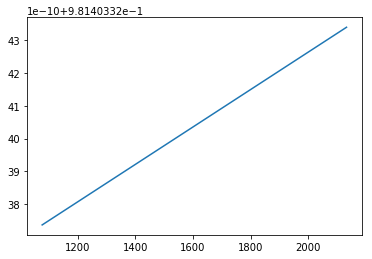

In [39]:
Plot(0, text = 'val_acc', label = '')
print(history[0].history['val_acc'])

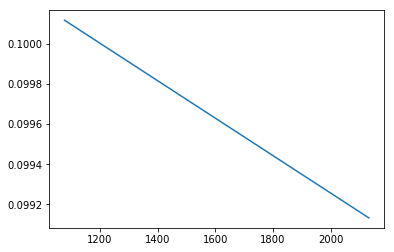

In [8]:
Plot(0, text = 'val_loss', label = '')

# Plot prediction

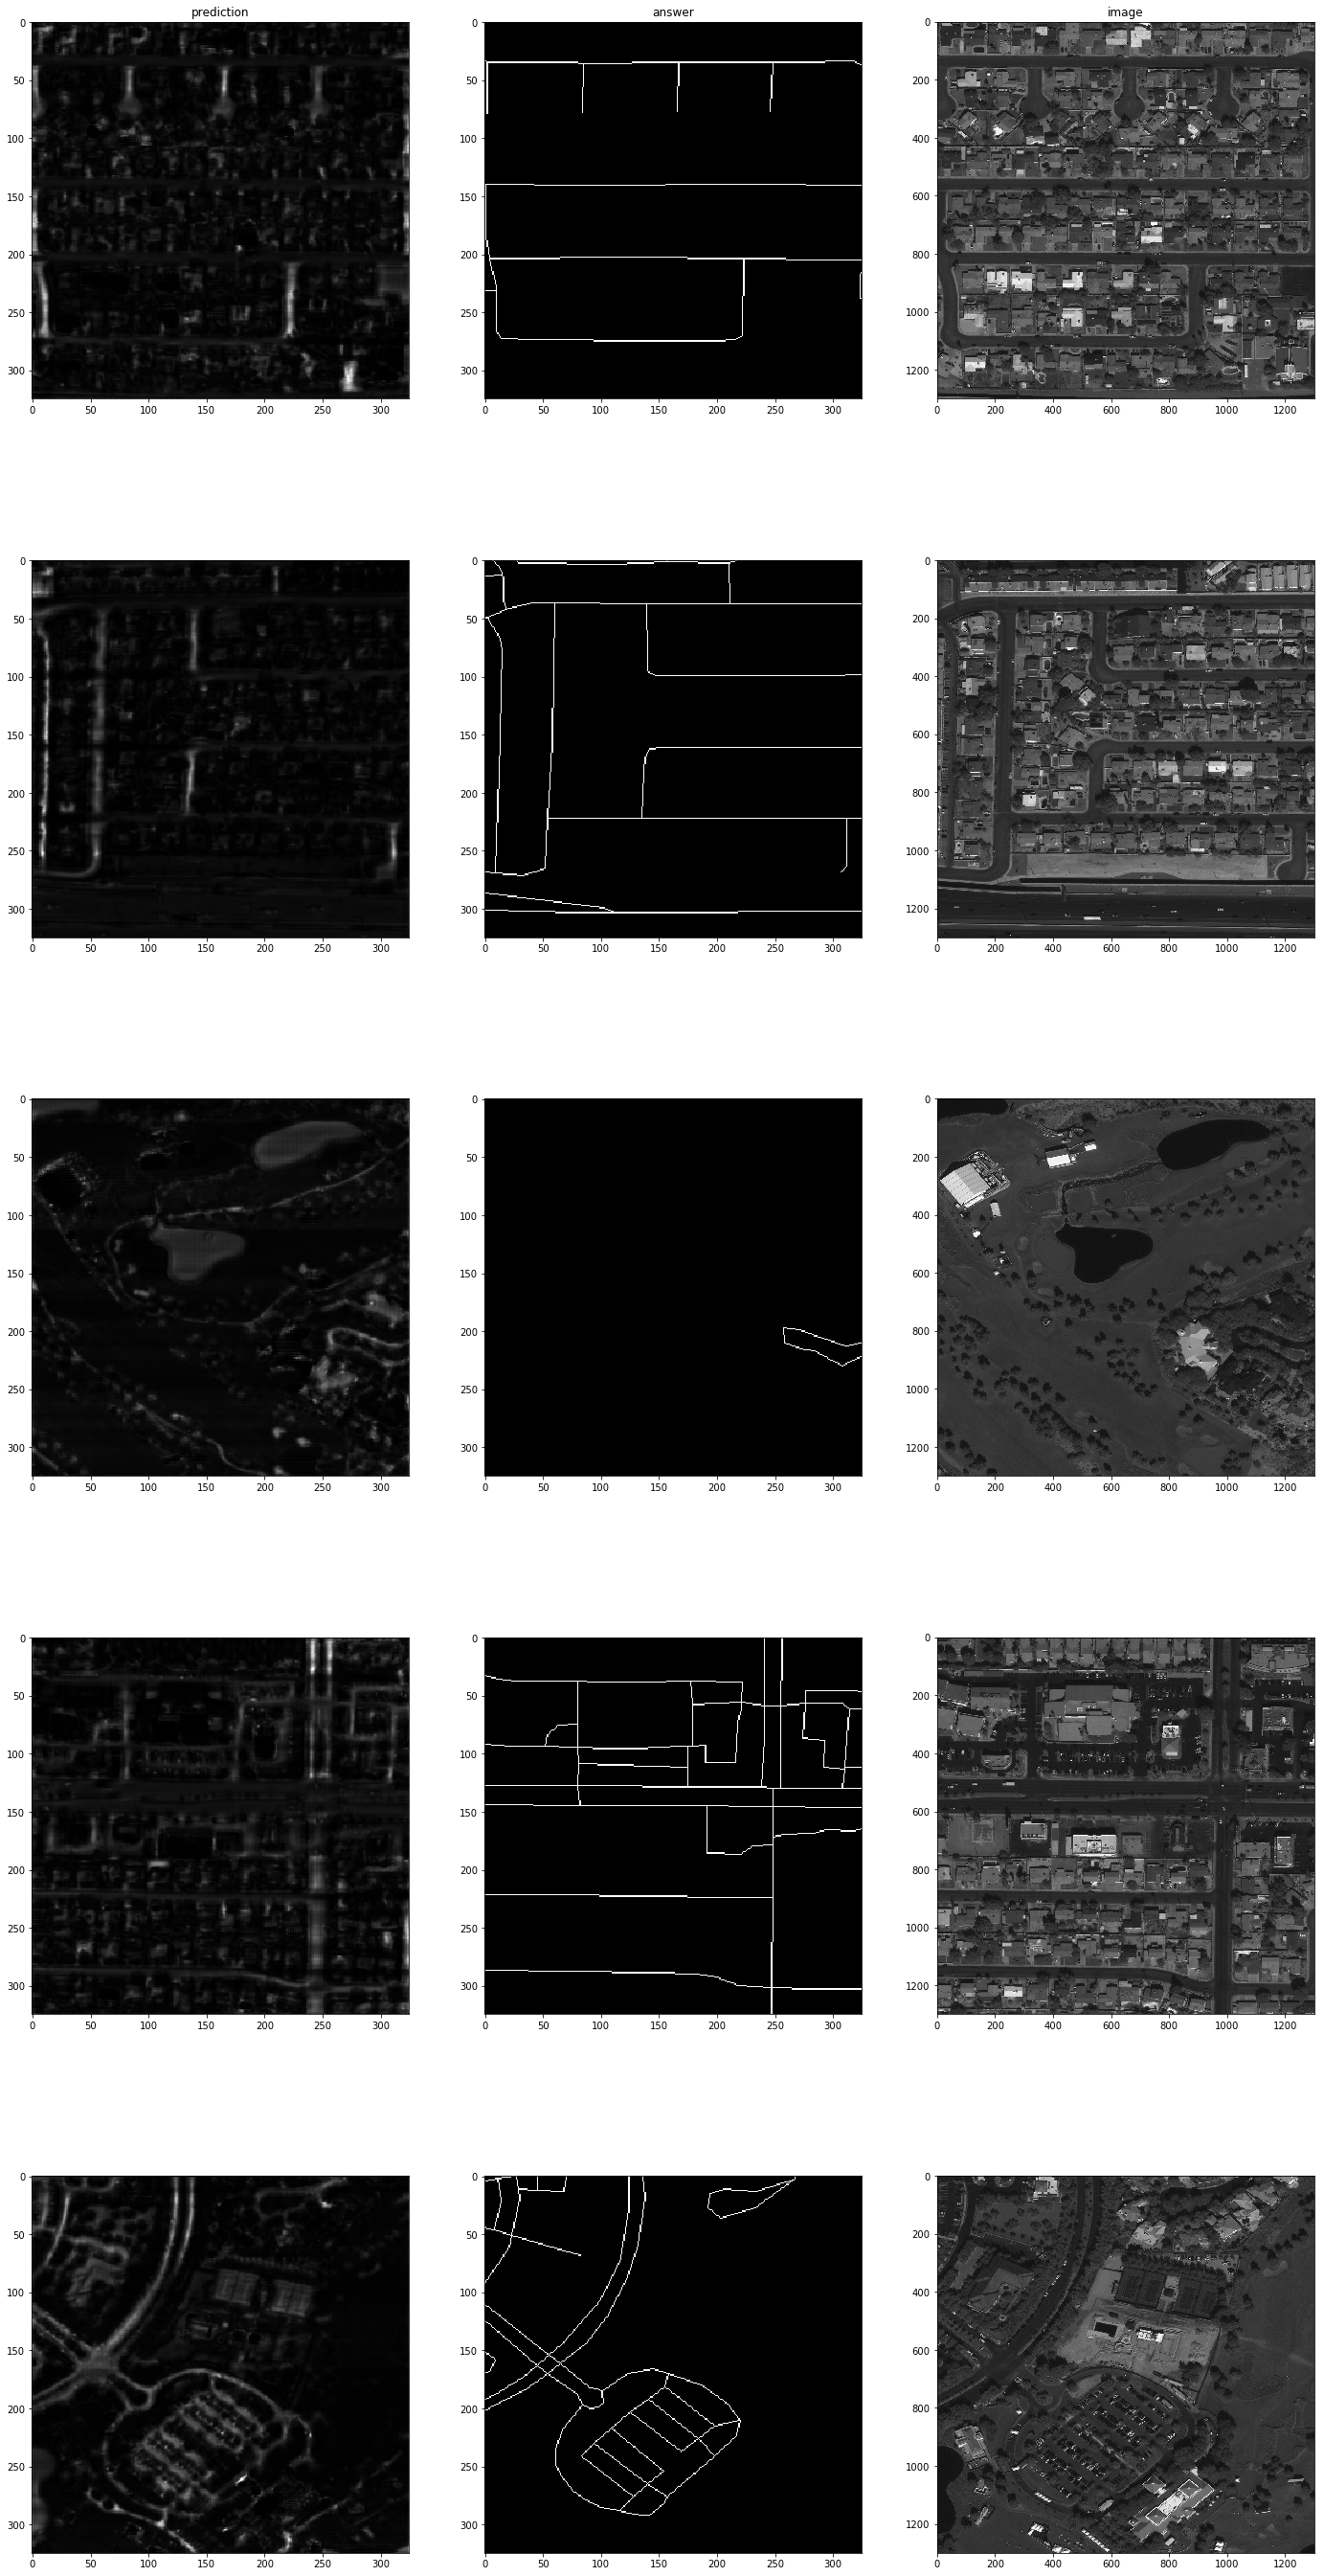

In [25]:
nimages = 5
plt.figure(figsize=(24, 10*nimages))
#pred = modelList[0].predict([xMulVal[:nimages],xPanVal[:nimages]])
for i in range(nimages):
    plt.subplot(nimages,3,i*3+1)
    plt.imshow(pred[i], cmap='gray')
    if i == 0:
        plt.title('prediction')
    
    plt.subplot(nimages,3,i*3+2)
    plt.imshow(yVal[i], cmap='gray')
    if i == 0:
        plt.title('answer')
    
    plt.subplot(nimages,3,i*3+3)
    plt.imshow(xPanVal[i][0], cmap='gray')
    if i == 0:
        plt.title('image')

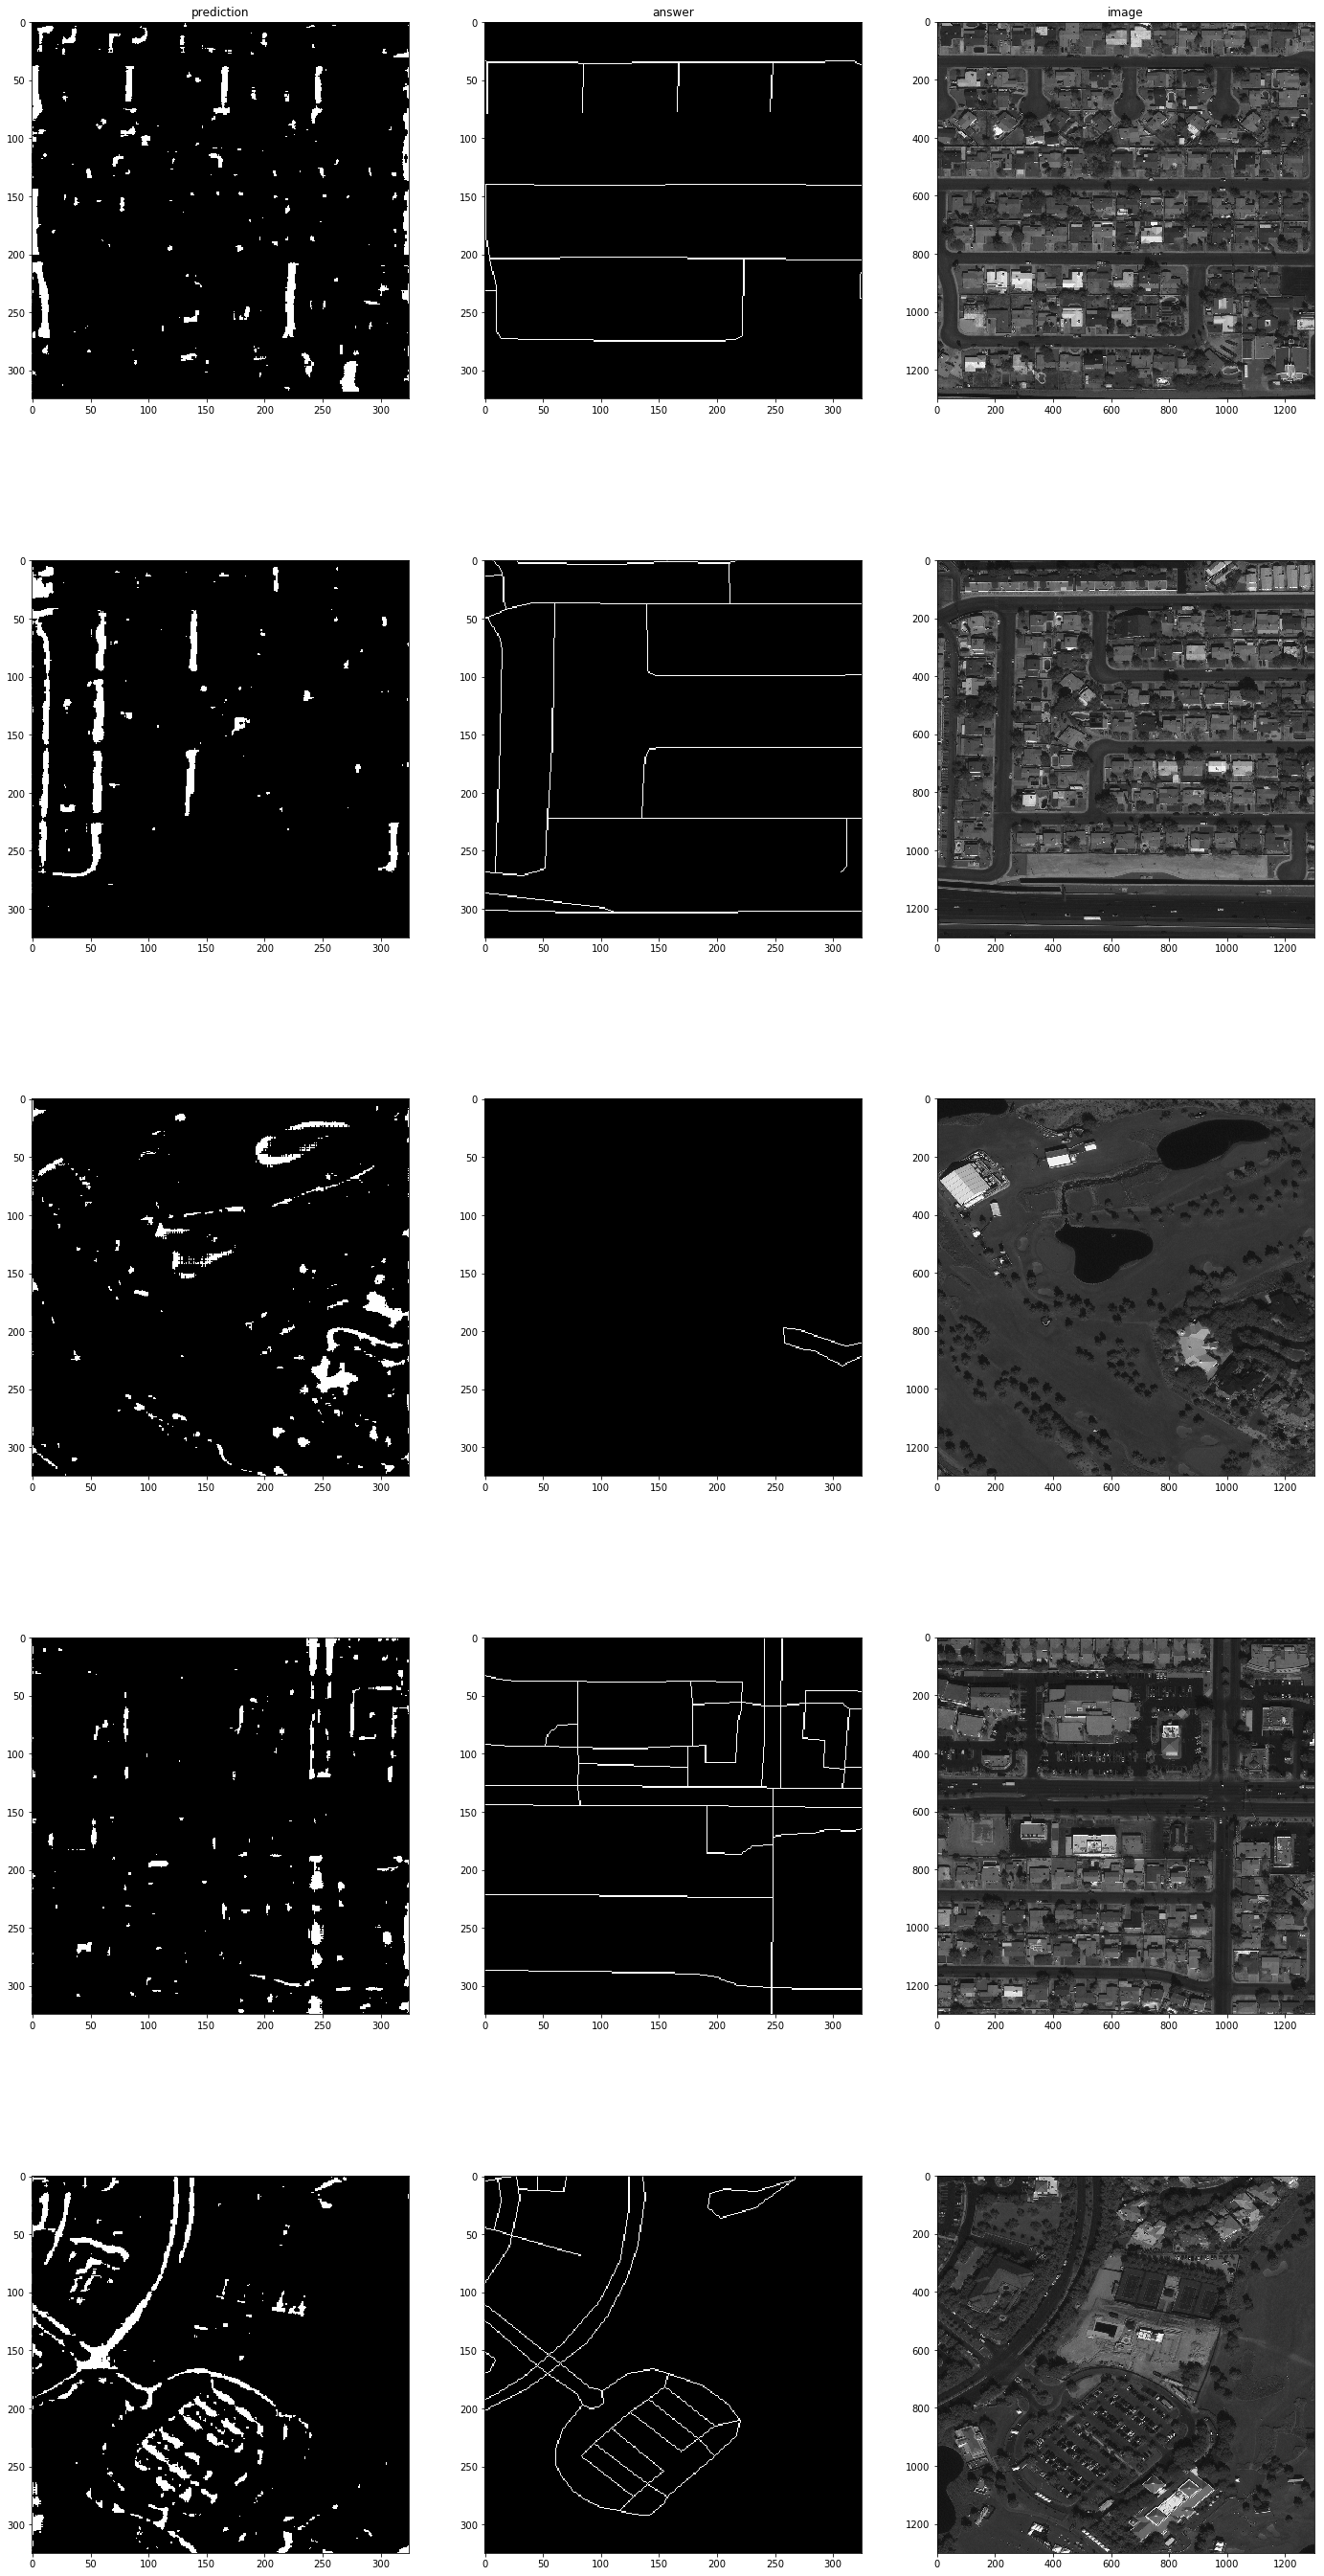

In [34]:
# Use heaviside to see more clearly
# It is terrible, I don't undertand why it claims to have such high accuracy. Also, I don't understand why I need to use 0.01
# for heaviside rather tham 0.5.
# We can see that is is somewhat learning, so the training is not off, but the value for acc and loss seems to be.

nimages = 5
plt.figure(figsize=(24, 10*nimages))
#pred = modelList[0].predict([xMulVal[:nimages],xPanVal[:nimages]])
for i in range(nimages):
    plt.subplot(nimages,3,i*3+1)
    plt.imshow(np.heaviside(pred[i]-0.01,0.5), cmap='gray')
    if i == 0:
        plt.title('prediction')
    
    plt.subplot(nimages,3,i*3+2)
    plt.imshow(yVal[i], cmap='gray')
    if i == 0:
        plt.title('answer')
    
    plt.subplot(nimages,3,i*3+3)
    plt.imshow(xPanVal[i][0], cmap='gray')
    if i == 0:
        plt.title('image')

In [45]:
# get the real accuracy
# y_pred and y_true are reshaped in a 1d array, so each pixel of each image is compared to itself (same image, same position)

from sklearn.metrics import accuracy_score

y_pred = np.reshape(modelList[0].predict([xMulVal,xPanVal]),(-1,))
y_true = np.reshape(yVal,(-1,))
print(accuracy_score(y_true, y_pred))

ResourceExhaustedError: OOM when allocating tensor with shape[32,48,325,325]
	 [[Node: batch_normalization_3/moments/Sub = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_3/Relu, batch_normalization_3/moments/StopGradient)]]
	 [[Node: reshape_1/Reshape/_673 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2986_reshape_1/Reshape", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'batch_normalization_3/moments/Sub', defined at:
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-30a4159a8818>", line 25, in <module>
    train(batchsize=1, nepochs=2, timelimit=3600)
  File "<ipython-input-2-a128be2fda64>", line 58, in train
    Y = NN(XMul,XPan)
  File "<ipython-input-4-30a4159a8818>", line 20, in NN
    x = tiramisu(x, blocks=[2,2,2], bottleneck = 2, input_shape=(8+num_channel_Pan, 325, 325))
  File "<ipython-input-3-9d24d8306db6>", line 24, in tiramisu
    x = _dense_block(nb, x, end2end=True)
  File "<ipython-input-3-9d24d8306db6>", line 76, in _dense_block
    lyr = _layer(x)
  File "<ipython-input-3-9d24d8306db6>", line 62, in _layer
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\normalization.py", line 177, in call
    epsilon=self.epsilon)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 1650, in normalize_batch_in_training
    shift=None, name=None, keep_dims=False)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\ops\nn_impl.py", line 642, in moments
    math_ops.subtract(y, shift), axes, keep_dims=True, name="shifted_mean")
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\ops\math_ops.py", line 305, in subtract
    return gen_math_ops._sub(x, y, name)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2501, in _sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,48,325,325]
	 [[Node: batch_normalization_3/moments/Sub = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_3/Relu, batch_normalization_3/moments/StopGradient)]]
	 [[Node: reshape_1/Reshape/_673 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2986_reshape_1/Reshape", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


# Redo, try to correct mistake for accuracy

In TiramisuInria.ipynb, they use loss='kld', metrics=["accuracy"] and they use the final reshape of tiramisu

_output = layers.Reshape((-1, n_classes))(x)

I think we don't need n_classes since there is 2 classes so one number is enough

In [4]:
yVal = np.reshape(yVal,(99,325*325))

In [7]:
def generator(batchsize):
    while True:
        for i in range(10):
            #print('  file', i)
            xMul = np.load(r'..\data\xMul'+str(i)+'.npy')
            xPan = np.load(r'..\data\xPan'+str(i)+'.npy')
            y = np.load(r'..\data\y325_'+str(i)+'.npy') # I will use the 325x325 resolution for the target
            xMul = (xMul - 414.1505843473475)/271.51272549425477
            xPan = (xPan - 532.8910415421709)/318.8023222567299
            j=0
            while j<xMul.shape[0]:
                #print('    ',j, '/', xMul.shape[0])
                yield ([xMul[j:j+batchsize], xPan[j:j+batchsize]], np.reshape(y[j:j+batchsize],(-1,325*325)))
                j+= batchsize

def tiramisu(_input, blocks=[4, 5, 7, 10, 12], bottleneck=15,  # architecture of the tiramisu
    n_classes=1, input_shape=(8, 325, 325)):  # properties of the data

    ##########################
    # image input # I use my own input
    #_input = layers.Input(shape=input_shape)
    ##########################
    # conv layer
    x = layers.Convolution2D(48, (3, 3), strides=(1, 1),
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(_input)
    ##########################
    # down path
    skips = []
    for nb in blocks:
        x = _dense_block(nb, x, end2end=True)
        skips.append(x)
        x = _transition_down(x)
    ##########################
    # bottleneck
    x = _dense_block(bottleneck, x)
    ##########################
    # up path
    for nb in blocks[::-1]:
        tmp = skips.pop() # need to do try except for odd number, can only pop once
        try:
            x = layers.Concatenate(axis=1)([_transition_up(x), tmp]) # axis=1 because I use channel first
        except ValueError:
            x = layers.Concatenate(axis=1)([layers.ZeroPadding2D(((1, 0), (1, 0)))(_transition_up(x)), tmp])
        x = _dense_block(nb, x)
    ##########################
    # conv layer
    x = layers.Convolution2D(n_classes, (1, 1), strides=(1, 1),
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    ##########################
    # segmented image output
    x = layers.Activation('softmax')(x)
    #_output = layers.Reshape((-1, n_classes))(x)
    ####################################################
    # put it together
    #model = Model(inputs=_input, outputs=_output)
    #return model
    return layers.Reshape((-1,))(x)

K.set_image_data_format("channels_first")
def NN(XMul,XPan): # XMul is of shape (100, 8, 325, 325), XPan is (100, 1, 1300, 1300), output is (100, 1300, 1300)
    num_channel_Pan = 8
    
    x = layers.Conv2D(num_channel_Pan//2,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(XPan) # need to do 2x2 pooling twice
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Conv2D(num_channel_Pan,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    
    x = layers.Concatenate(axis=1)([x,XMul]) # channel axis
    # I think it needs to be dividible 32 times, so it needs 320 or 352. I put a try except to do the padding just when needed
    x = tiramisu(x, blocks=[2,2,2], bottleneck = 2, input_shape=(8+num_channel_Pan, 325, 325))
    return x

def train(batchsize=99, nepochs=10, timelimit=np.inf):
    XMul = layers.Input(shape=xMulVal.shape[1:])
    XPan = layers.Input(shape=xPanVal.shape[1:])
    
    # Actual neural netowrk given by function NN
    Y = NN(XMul,XPan)
    
    model = Model(inputs=[XMul,XPan], outputs=Y)

    time_callback = TimeHistory(timelimit)
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='kld')
    history.append(model.fit_generator(generator(batchsize), steps_per_epoch=882//batchsize, max_queue_size = 2,
                   epochs=nepochs, verbose=2, validation_data=([xMulVal,xPanVal],yVal),callbacks=[time_callback, es]))
    xaxis.append(time_callback.times)
    modelList.append(model) 

In [8]:
train(batchsize=1, nepochs=1, timelimit=3600)

Epoch 1/1
1162s - loss: 9797.4891 - acc: 0.0000e+00 - val_loss: 8886.0923 - val_acc: 0.0000e+00


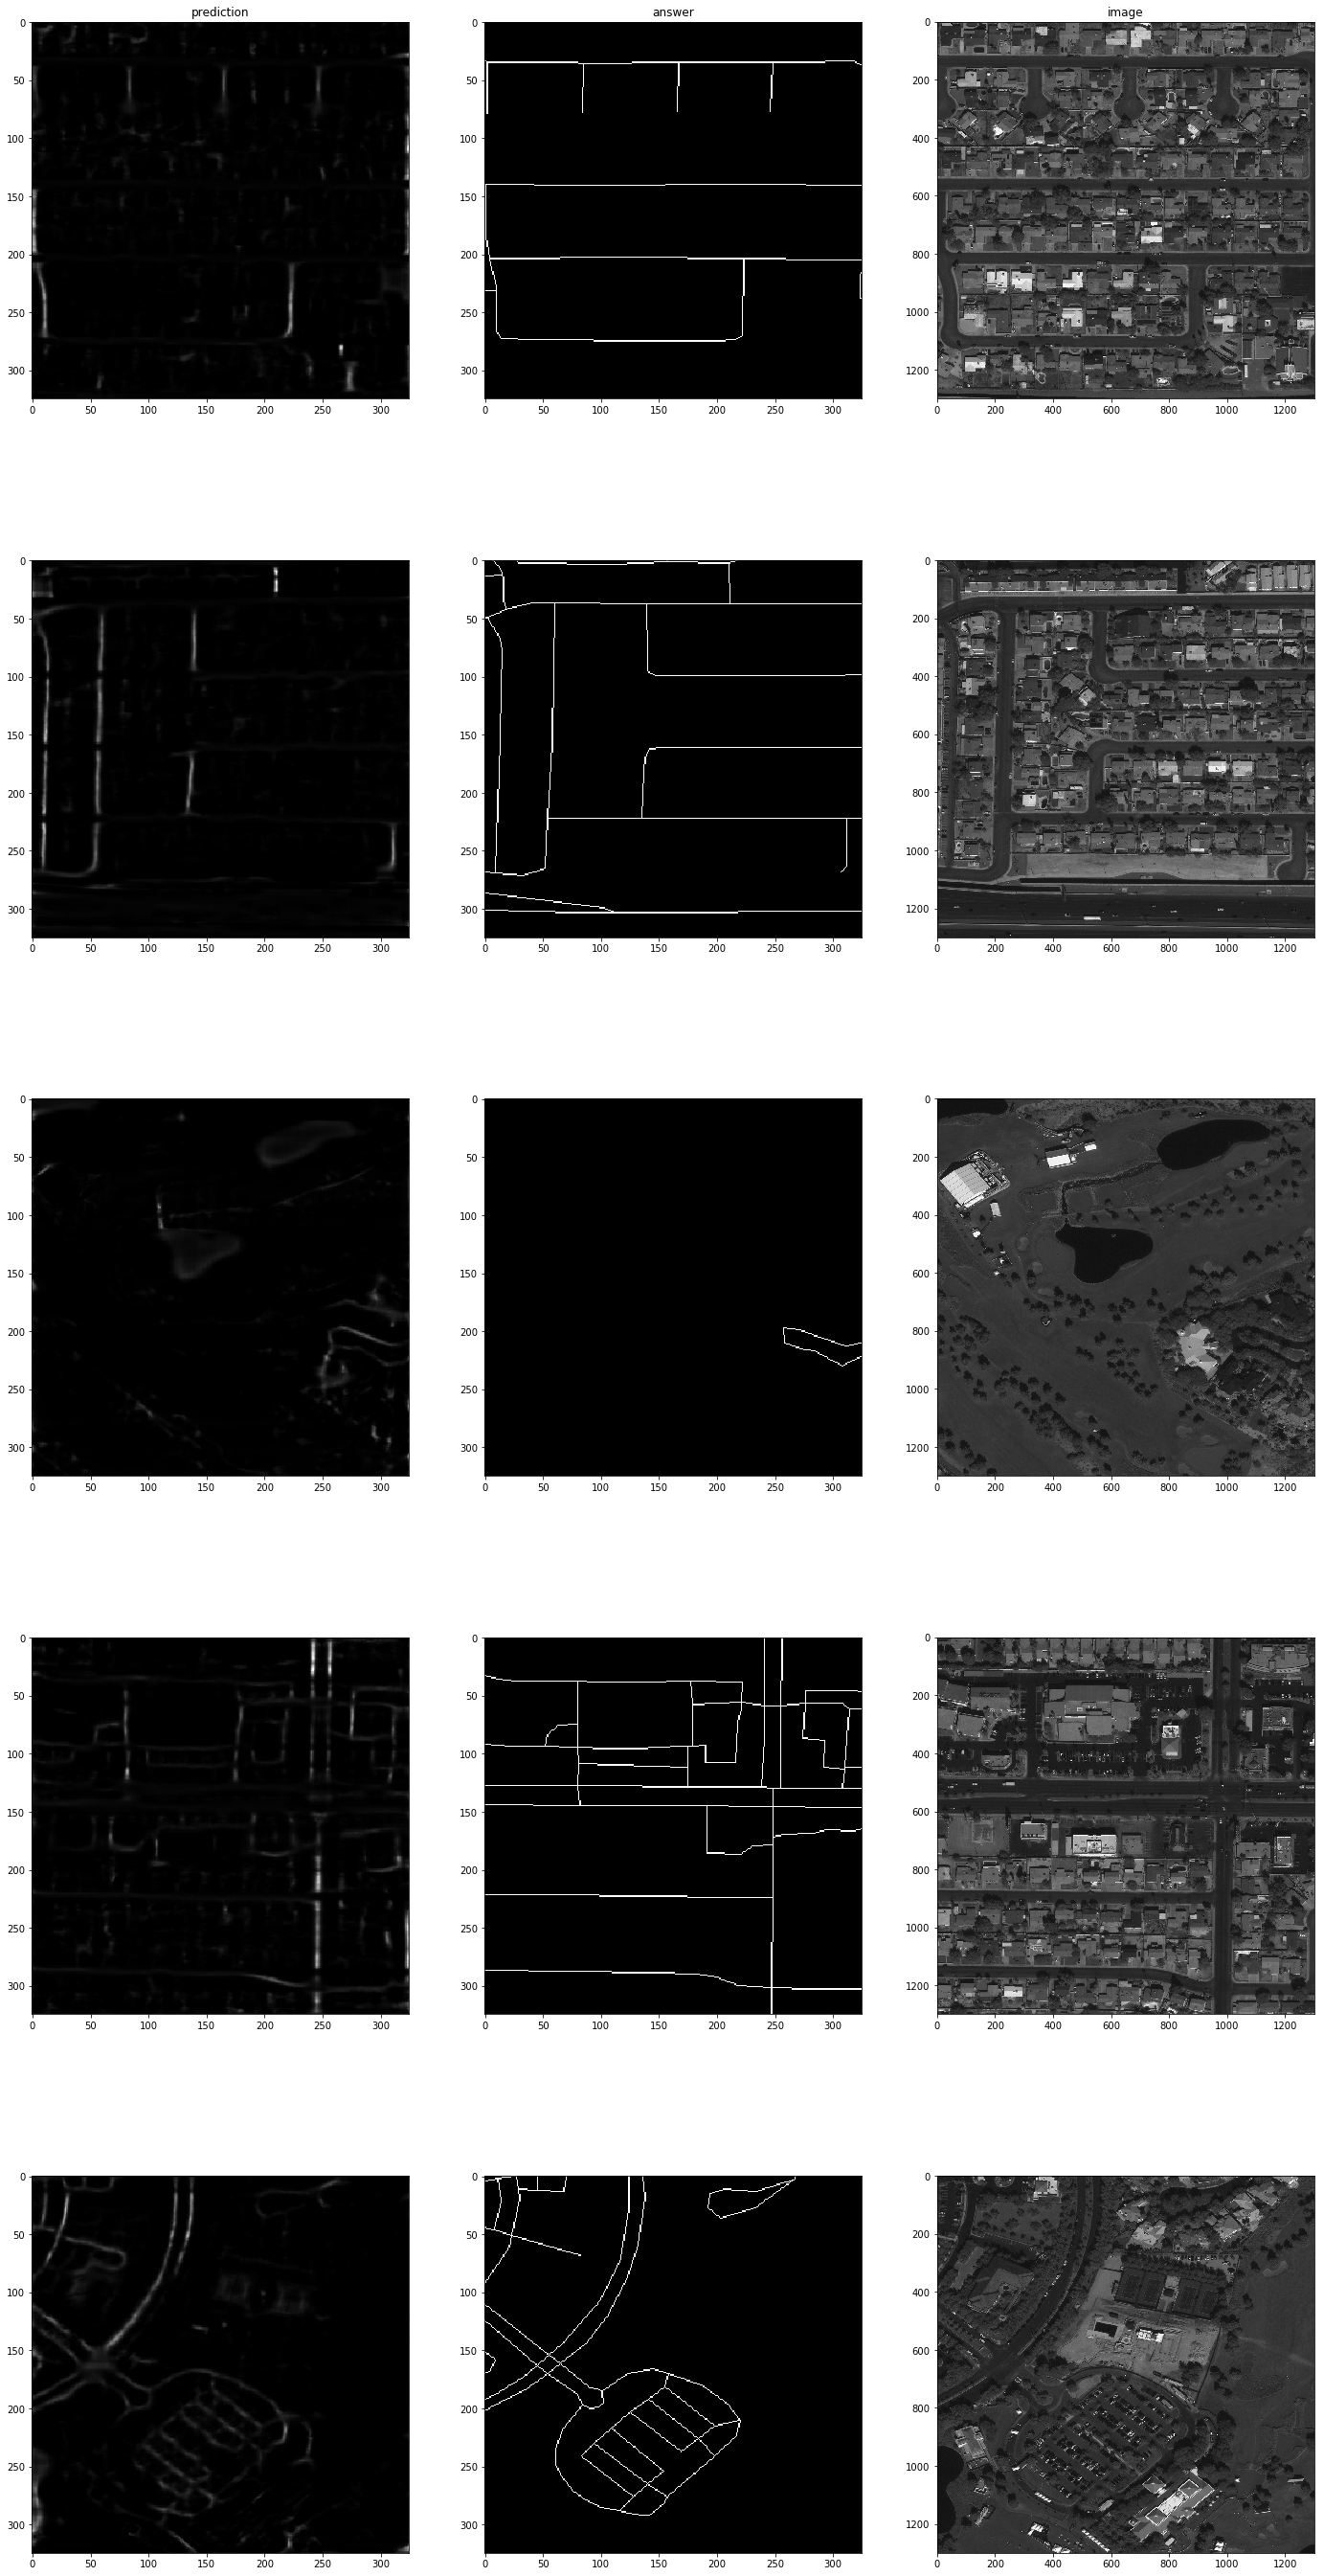

In [11]:
nimages = 5
plt.figure(figsize=(24, 10*nimages))
pred = np.reshape(modelList[0].predict([xMulVal[:nimages],xPanVal[:nimages]]),(nimages,325,325))
for i in range(nimages):
    plt.subplot(nimages,3,i*3+1)
    plt.imshow(pred[i], cmap='gray')
    if i == 0:
        plt.title('prediction')
    
    plt.subplot(nimages,3,i*3+2)
    plt.imshow(np.reshape(yVal[i],(325,325)), cmap='gray')
    if i == 0:
        plt.title('answer')
    
    plt.subplot(nimages,3,i*3+3)
    plt.imshow(xPanVal[i][0], cmap='gray')
    if i == 0:
        plt.title('image')

In [1]:
# The kernel died

# Thoughts

### Model list

Modellist is useless with this model because my memory is unable to have more than one model. So I should just have one model in the variable model rather than trying to save them all.

### accuracy

Keras doesn't explain what metrics it uses with 'acc'. It could be

def binary_accuracy(y_true, y_pred):

  return K.mean(math_ops.equal(y_true, math_ops.round(y_pred)), axis=-1)

or

def categorical_accuracy(y_true, y_pred):

  return math_ops.cast(
  
      math_ops.equal(
      
          math_ops.argmax(y_true, axis=-1), math_ops.argmax(y_pred, axis=-1)),
          
      K.floatx())
      
https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/python/keras/metrics.py

In the 1st version, I think: The accuracy is very high even though the prediction is 0 everywhere (always bellow 0.5) because the answer is 0 almost everywhere, only a few pixel are 1s.

I'm confuse as to why the accuracy is 0 in the 2nd version. Maybe it is because it thinks it is a categorical_accuracy and does an argmax.

In any case, the problem is that accuracy is not a good measure because of the class imbalance between 0 and 1.

This paper: https://hal.inria.fr/hal-01581525/document talks about a new metrics for semantic segmentation.

They say the standard is The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient. That's
sum(y_pred \* y_true)/(sum(y_pred)+sum(y_true)-sum(y_pred \* y_true)) since y_pred*y_true is the union (if y_pred and y_true are 1s and 0s)

They advise to combine it with the border metric BF.

However, another metrics might be better for road

### Loss

https://www.jeremyjordan.me/semantic-segmentation/

This paper says that pixel-wise cross entropy loss is commonly used

Another one is the Dice coefficient, which is 1 - 2*intersection over the sum of the sizes.

Loss needs to be the smaller the better, so needs 1-.

In [ ]:
from tensorflow.python.ops import math_ops

def IoU_metrics(y_true, y_pred):
    yrounded = math_ops.round(y_pred) # round so that less than 0.5 is 0 and more is 1
    return K.mean(K.sum(yrounded*y_true)/(K.sum(yrounded)+K.sum(y_true)-K.sum(yrounded*y_true)))

# Need to sum over all pixels of an image, but take the mean of all images at the end


In [ ]:
history = []
xaxis = []
class TimeHistory(callbacks.Callback):
    def __init__(self, seconds=np.inf):
        super(callbacks.Callback, self).__init__()
        self.seconds = seconds
    def on_train_begin(self, logs={}):
        self.times = []
        self.start = time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.start)
        if time() - self.start > self.seconds: # if not defined, there is no limit since it is np.inf
            self.model.stop_training = True
            print('Stopping after %s seconds.' % self.seconds)
                
def Plot(i, text = 'val_acc', label = ''):
    plt.plot(xaxis[i], history[i].history[text], label = label)
    
def retrain(model, batchsize=99, nepochs=10, timelimit=np.inf):
    time_callback = TimeHistory(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    history[i_model].history = list(history[i_model].history)
    history[i_model].history.append(modelList[i_model].fit_generator(generator(batchsize), 
                    steps_per_epoch(989-yVal.shape[0])//batchsize,
                   epochs=nepochs, verbose=2, validation_data=([xMulVal,xPanVal],yVal),callbacks=[time_callback, es]))
    xaxis[i_model].append(time_callback.times)
    
def generator(batchsize):
    while True:
        for i in range(10):
            #print('  file', i)
            xMul = np.load(r'..\data\xMul'+str(i)+'.npy')
            xPan = np.load(r'..\data\xPan'+str(i)+'.npy')
            y = np.load(r'..\data\y325_'+str(i)+'.npy') # I will use the 325x325 resolution for the target
            xMul = (xMul - 414.1505843473475)/271.51272549425477
            xPan = (xPan - 532.8910415421709)/318.8023222567299
            j=0
            while j<xMul.shape[0]:
                #print('    ',j, '/', xMul.shape[0])
                yield ([xMul[j:j+batchsize], xPan[j:j+batchsize]], y[j:j+batchsize])
                j+= batchsize
                
# load Validation data
xMulVal = np.load(r'..\data\xMulVal.npy')
xPanVal = np.load(r'..\data\xPanVal.npy')
yVal = np.load(r'..\data\yVal325.npy')
xMulVal = (xMulVal - 414.1505843473475)/271.51272549425477
xPanVal = (xPanVal - 532.8910415421709)/318.8023222567299

print(xMulVal.shape,xPanVal.shape, yVal.shape)

def train(batchsize=99, nepochs=10, timelimit=np.inf):
    XMul = layers.Input(shape=xMulVal.shape[1:])
    XPan = layers.Input(shape=xPanVal.shape[1:])
    
    # Actual neural netowrk given by function NN
    Y = NN(XMul,XPan)
    
    model = Model(inputs=[XMul,XPan], outputs=Y)

    time_callback = TimeHistory(timelimit)
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    model.compile(optimizer='adam', metrics=[IoU_metrics],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(batchsize), steps_per_epoch=882//batchsize,
                   epochs=nepochs, verbose=2, validation_data=([xMulVal,xPanVal],yVal),callbacks=[time_callback, es]))
    xaxis.append(time_callback.times)
    return model